In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import shap
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
df = pd.read_csv("bert_sentiment.csv")
df = df[df["bert_sentiment_label"].isin(["neutral", "positive", "negative"])]

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["bert_sentiment_label"].map(label2id)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["bert_clean"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels})
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
).to("cuda")

training_args = TrainingArguments(
    output_dir="./bert_sentiment_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Map:   0%|          | 0/34681 [00:00<?, ? examples/s]

Map:   0%|          | 0/8671 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4-2060379178.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.326000,0.321799,0.877292,0.857388
2,0.227500,0.435484,0.889978,0.873078
3,0.103600,0.582041,0.892515,0.876348


TrainOutput(global_step=13008, training_loss=0.237122962533108, metrics={'train_runtime': 3626.0406, 'train_samples_per_second': 28.693, 'train_steps_per_second': 3.587, 'total_flos': 9524994529841028.0, 'train_loss': 0.237122962533108, 'epoch': 3.0})

In [10]:
model.eval()

texts = [
    "I love this movie!",
    "This is a standard procedure.",
    "This was the worst experience ever."
]

for text in texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()
        print(f"{text} → {id2label[pred]}")


I love this movie! → positive
This is a standard procedure. → neutral
This was the worst experience ever. → negative


In [9]:
df["bert_sentiment_label"].value_counts()


,count
bert_sentiment_label,
positive,20177
negative,13041
neutral,10134


In [11]:
trainer.evaluate()


{'eval_loss': 0.5820412635803223,
 'eval_accuracy': 0.8925152808211279,
 'eval_f1': 0.8763482646481036,
 'eval_runtime': 43.1875,
 'eval_samples_per_second': 200.776,
 'eval_steps_per_second': 25.1,
 'epoch': 3.0}

In [12]:
from sklearn.metrics import classification_report

preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))


              precision    recall  f1-score   support

    negative       0.90      0.91      0.90      2608
     neutral       0.81      0.77      0.79      2027
    positive       0.93      0.94      0.94      4036

    accuracy                           0.89      8671
   macro avg       0.88      0.87      0.88      8671
weighted avg       0.89      0.89      0.89      8671



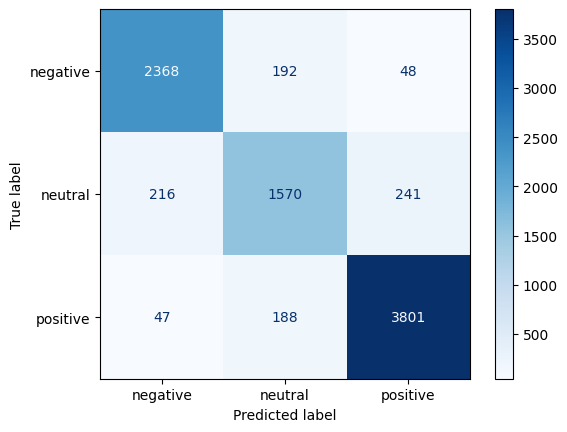

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues")
plt.show()


## 1 Model

PartitionExplainer explainer: 1001it [26:12,  1.58s/it]



 Top słowa dla klasy: negative
     crude | impact: 0.02043
    change | impact: -0.01700
    dollar | impact: 0.01134
       100 | impact: -0.01021
       200 | impact: 0.00802
      much | impact: -0.00591
     focus | impact: -0.00575
      buys | impact: 0.00556
       que | impact: -0.00554
      chen | impact: 0.00533
   coulter | impact: 0.00533
       bon | impact: -0.00507
 breakfast | impact: 0.00475
  fighting | impact: 0.00439
    course | impact: -0.00336

 Top słowa dla klasy: neutral
       its | impact: 0.88241
  requires | impact: -0.78641
transformers | impact: 0.75389
       job | impact: -0.73208
      pete | impact: 0.69469
 messaging | impact: -0.68361
      west | impact: 0.67490
  recovery | impact: 0.63372
     false | impact: -0.56863
     scary | impact: 0.50045
      erin | impact: 0.49987
    arabia | impact: 0.49982
connecticut | impact: -0.49982
     saudi | impact: -0.49977
burlington | impact: 0.49956

 Top słowa dla klasy: positive
     place | impact

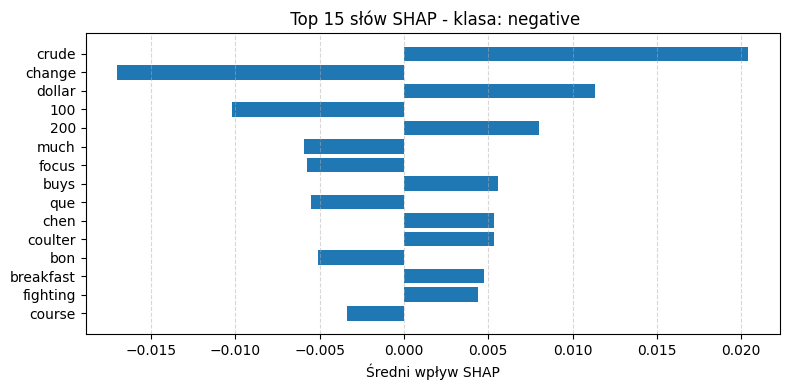

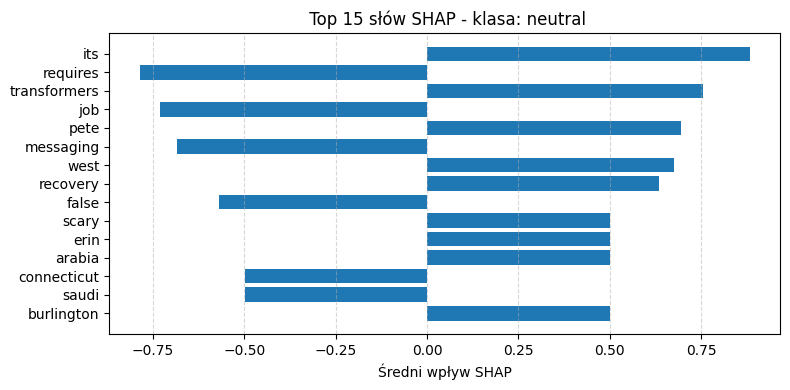

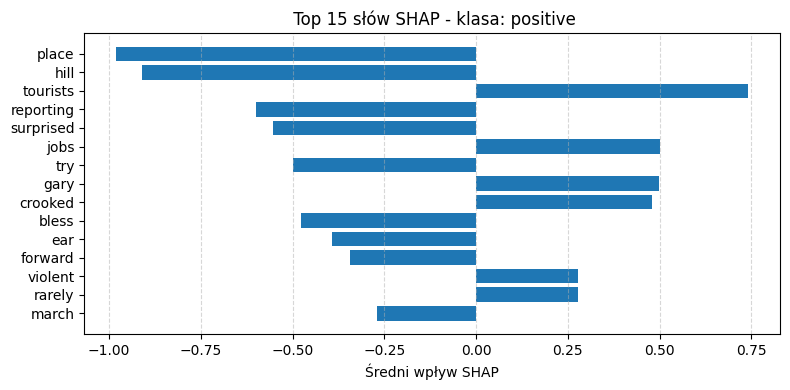

In [39]:
# 1. Przygotuj dane (1000 przykładów)
texts_for_shap = list(val_ds["text"][:1000])

# 2. Funkcja predykcyjna z obsługą GPU
def predict_proba(texts):
    if isinstance(texts, dict):
        texts = texts.get("text", texts)

    clean_texts = []
    for t in texts:
        if t is None:
            continue
        elif isinstance(t, list):
            clean_texts.append(" ".join(t))
        else:
            clean_texts.append(str(t))

    encoded = tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    encoded = {k: v.to("cuda") for k, v in encoded.items()}
    model.eval()
    model.to("cuda")
    with torch.no_grad():
        outputs = model(**encoded)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# 3. SHAP setup (nie trzeba na GPU – działa CPU)
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model=predict_proba, masker=masker, output_names=["negative", "neutral", "positive"])

# 4. Oblicz wartości SHAP
shap_values = explainer(texts_for_shap)

# 5. Zbierz i uśrednij wpływy tokenów
token_impact = [defaultdict(list) for _ in range(3)]  # dla każdej klasy

for sv in shap_values:
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(" ".join(sv.data), add_special_tokens=False))
    tokens = [tok for tok in tokens if len(tok.replace("#", "")) >= 3 and not tok.startswith("##")]

    for i in range(3):  # 3 klasy
        for j, token in enumerate(tokens):
            if j < len(sv.values[i]):
                token_impact[i][token].append(sv.values[i][j])

# 6. Oblicz średnie wpływy i posortuj
top_words_per_class = []
for i in range(3):
    avg_impact = {tok: np.mean(vals) for tok, vals in token_impact[i].items()}
    sorted_tok = sorted(avg_impact.items(), key=lambda x: abs(x[1]), reverse=True)[:15]
    top_words_per_class.append(sorted_tok)

# 7. Wyświetl tabelę
for class_idx, class_name in enumerate(["negative", "neutral", "positive"]):
    print(f"\n Top słowa dla klasy: {class_name}")
    for word, val in top_words_per_class[class_idx]:
        print(f"{word:>10} | impact: {val:.5f}")

# 8. Wykresy
for class_idx, class_name in enumerate(["negative", "neutral", "positive"]):
    words, values = zip(*top_words_per_class[class_idx])
    plt.figure(figsize=(8, 4))
    plt.barh(words[::-1], values[::-1])
    plt.title(f" Top 15 słów SHAP - klasa: {class_name}")
    plt.xlabel("Średni wpływ SHAP")
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## 2 Model

PartitionExplainer explainer: 101it [02:44,  1.69s/it]



 Top 10 pozytywnych słów dla klasy: negative
       crude | impact: 0.02043
        buys | impact: 0.00556
         mer | impact: 0.00455
         can | impact: 0.00190
     amazing | impact: 0.00068
      leader | impact: 0.00052
         mas | impact: 0.00050
   president | impact: 0.00045
       china | impact: 0.00035
         isn | impact: 0.00035

Top 10 negatywnych słów dla klasy: negative
         100 | impact: -0.02042
        much | impact: -0.00591
       focus | impact: -0.00575
     turning | impact: -0.00262
         fox | impact: -0.00227
     already | impact: -0.00180
        that | impact: -0.00103
        disc | impact: -0.00069
         out | impact: -0.00037
         and | impact: -0.00018

 Top 10 pozytywnych słów dla klasy: neutral
         its | impact: 0.88241
    mistakes | impact: 0.44714
       evans | impact: 0.35391
         jai | impact: 0.31275
         new | impact: 0.31265
       green | impact: 0.29122
        gate | impact: 0.24566
        ohio | im

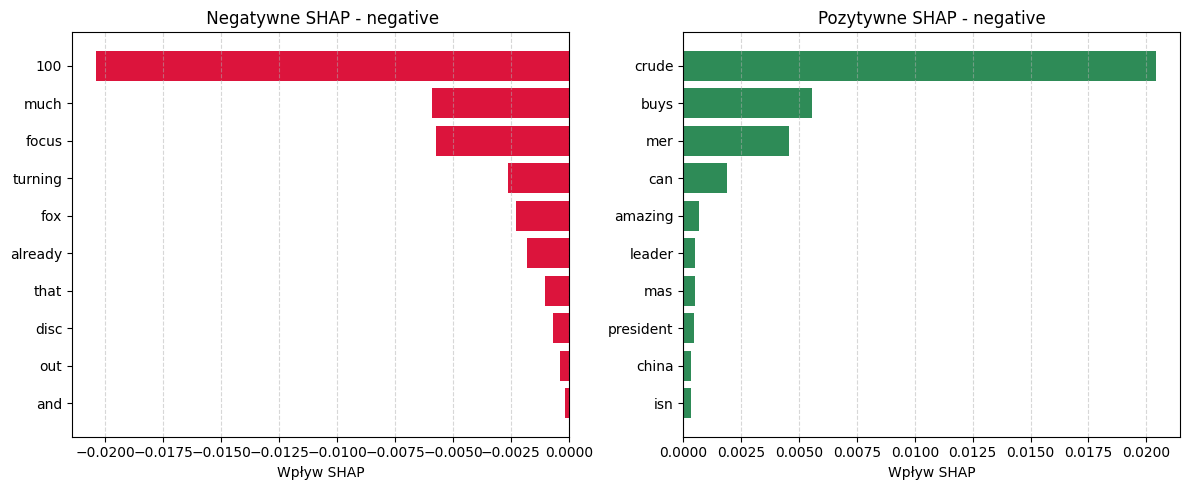

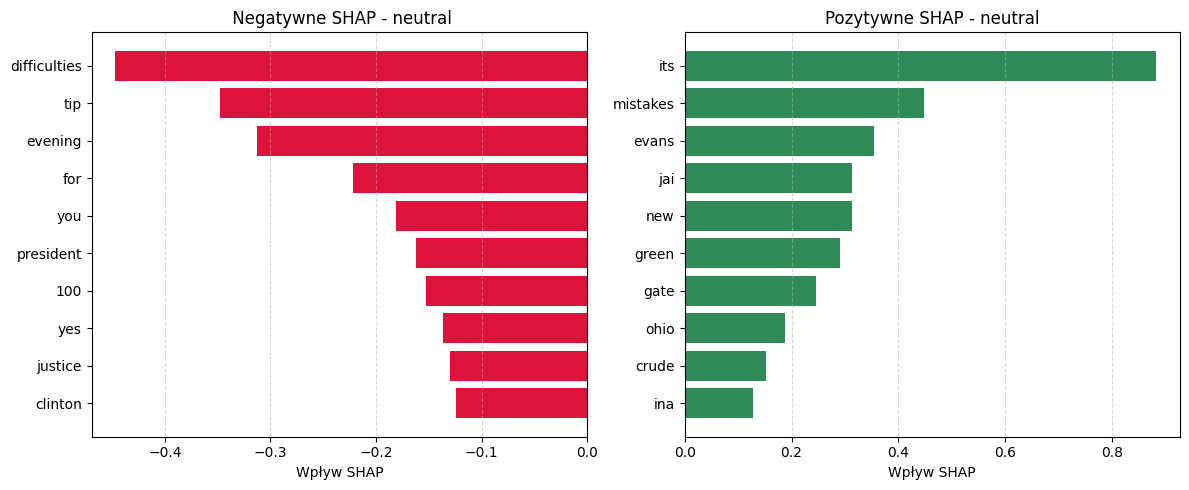

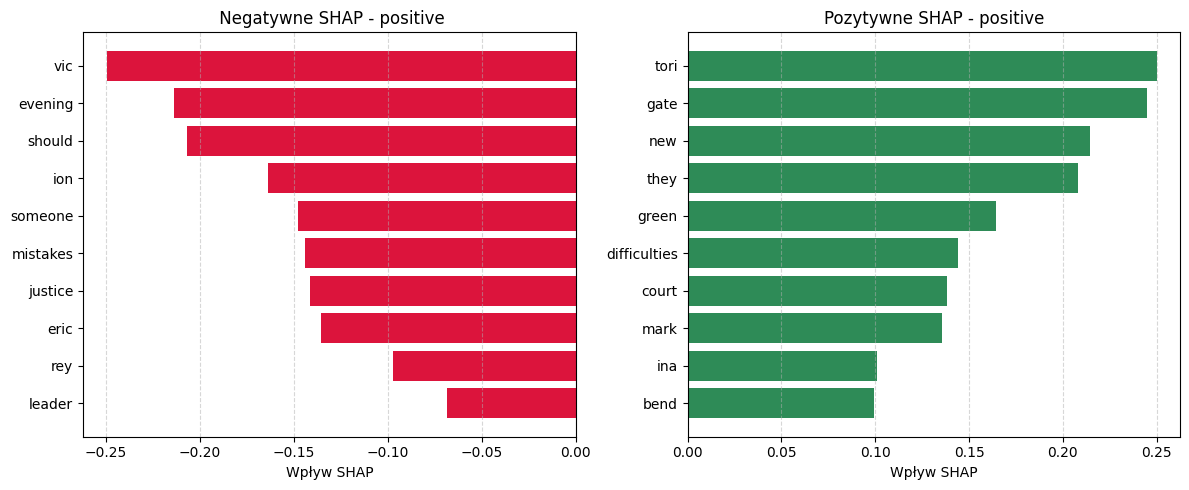

In [42]:
texts_for_shap = list(val_ds["text"][:100])

def predict_proba(texts):
    if isinstance(texts, dict):
        texts = texts.get("text", texts)

    clean_texts = []
    for t in texts:
        if t is None:
            continue
        elif isinstance(t, list):
            clean_texts.append(" ".join(t))
        else:
            clean_texts.append(str(t))

    encoded = tokenizer(
        clean_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    encoded = {k: v.to("cuda") for k, v in encoded.items()}
    model.eval()
    model.to("cuda")
    with torch.no_grad():
        outputs = model(**encoded)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model=predict_proba, masker=masker, output_names=["negative", "neutral", "positive"])

shap_values = explainer(texts_for_shap)


token_impact = [defaultdict(list) for _ in range(3)]
for sv in shap_values:
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(" ".join(sv.data), add_special_tokens=False))
    tokens = [tok for tok in tokens if len(tok.replace("#", "")) >= 3 and not tok.startswith("##")]
    for i in range(3):
        for j, token in enumerate(tokens):
            if j < len(sv.values[i]):
                token_impact[i][token].append(sv.values[i][j])

top_words_positive = []
top_words_negative = []

for i in range(3):
    avg_impact = {tok: np.mean(vals) for tok, vals in token_impact[i].items()}
    positive_words = sorted([(tok, val) for tok, val in avg_impact.items() if val > 0], key=lambda x: x[1], reverse=True)[:10]
    negative_words = sorted([(tok, val) for tok, val in avg_impact.items() if val < 0], key=lambda x: x[1])[:10]
    top_words_positive.append(positive_words)
    top_words_negative.append(negative_words)

for i, class_name in enumerate(["negative", "neutral", "positive"]):
    print(f"\n Top 10 pozytywnych słów dla klasy: {class_name}")
    for word, val in top_words_positive[i]:
        print(f"{word:>12} | impact: {val:.5f}")

    print(f"\nTop 10 negatywnych słów dla klasy: {class_name}")
    for word, val in top_words_negative[i]:
        print(f"{word:>12} | impact: {val:.5f}")

for i, class_name in enumerate(["negative", "neutral", "positive"]):
    pos_words, pos_values = zip(*top_words_positive[i]) if top_words_positive[i] else ([], [])
    neg_words, neg_values = zip(*top_words_negative[i]) if top_words_negative[i] else ([], [])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].barh(neg_words[::-1], neg_values[::-1], color='crimson')
    axs[0].set_title(f" Negatywne SHAP - {class_name}")
    axs[0].set_xlabel("Wpływ SHAP")
    axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

    axs[1].barh(pos_words[::-1], pos_values[::-1], color='seagreen')
    axs[1].set_title(f"Pozytywne SHAP - {class_name}")
    axs[1].set_xlabel("Wpływ SHAP")
    axs[1].grid(True, axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()